# Modeling & Evaluation

- [Topic Modeling](#topic_modeling)
- [Time Series Forecasting](#time_series_forecasting)

In [1]:
%load_ext autoreload
%autoreload 2

---

## Topic Modeling <a name="topic_modeling"></a>

### Modeling

#### *A*. Modeling

Der folgende Code importiert eigens speziell entwickelte Klassen und Methoden, die für das LDA-Topic-Modeling optimiert sind. Es wird empfohlen, diese Methode zur Erstellung der Modelle zu verwenden. Eine ausführlichere Darstellung des Codes befindet sich in der Datei `src/models/topic_modeling.py`

In [1]:
from src.models import topic_modeling as tm
from src.utils import safe_as_pkl
import pandas as pd

# load dataframe
df = pd.read_feather('../data/processed/twitter_tweets_processed.feather')

# create & build lda model
lda_model = tm.LdaModel(text=df['preprocessed_text'])
lda_model.build(num_topics=11)

# export
safe_as_pkl(lda_model, path='../models/lda_model.pkl')

2023-06-28 10:54:52,901 - INFO - Initialize model; create dictionary and corpus...
2023-06-28 10:55:31,081 - INFO - calculate lda model... (this can take a while)
2023-06-28 11:04:10,949 - INFO - Done. Model calculated successfully! Calculation time: 9.3937 minutes


#### *B*. Ergebnisse visualisieren

In [2]:
import pyLDAvis.gensim_models
from src.utils import load_pkl

lda_model = load_pkl('../models/lda_model.pkl')

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model.model, lda_model.corpus, lda_model.dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
10     0.146110 -0.049168       1        1  27.697330
4     -0.016247  0.238571       2        1   9.608113
9      0.266840 -0.139093       3        1   9.095626
1      0.132111  0.074939       4        1   8.049471
3     -0.151923 -0.123610       5        1   7.668676
0     -0.062984  0.069990       6        1   7.460806
8     -0.142890 -0.130109       7        1   7.252965
5     -0.101364 -0.044977       8        1   6.785574
2      0.177547  0.150462       9        1   6.400667
6     -0.213863  0.152483      10        1   5.317571
7     -0.033337 -0.199488      11        1   4.663201, topic_info=               Term           Freq          Total Category  logprob  loglift
57               ai  222582.000000  222582.000000  Default  30.0000  30.0000
53       innovation  365888.000000  365888.000000  Default  29.0000  29.0000
23    cybersecurity   58127.000000   58127.000000  Default  28.0000  28.0000
12          startup   63789.000000   63789.000000  Default  27.0000  27.0000
14             tech  499769.000000  499769.000000  Default  26.0000  26.0000
...             ...            ...            ...      ...      ...      ...
1292            art    6768.451188   23907.172260  Topic11  -4.7398   1.8036
14             tech   16022.659024  499769.983850  Topic11  -3.8780  -0.3747
1124          proud    4437.669043    7321.488252  Topic11  -5.1619   2.5648
53       innovation    7199.144736  365888.527427  Topic11  -4.6781  -0.8629
137            year    5340.517700   38194.531222  Topic11  -4.9767   1.0981

[598 rows x 6 columns], token_table=       Topic      Freq           Term
term                                 
5800      11  0.999742             ##
2316      11  0.999611             (#
5099      11  0.999806             ,#
3030       9  0.999941             --
7224      10  0.999985  100daysofcode
...      ...       ...            ...
137        7  0.000288           year
137        8  0.000052           year
137       11  0.139837           year
954        5  0.999862        youtube
46801     11  0.999784             ⁦⁩

[1094 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[11, 5, 10, 2, 4, 1, 9, 6, 3, 7, 8])

### Evaluation

#### 1. Coherence Score berechnen

Der Coherence Score ist ein Evaluationsmaß für Topic Models, das versucht, die Kohärenz der gefundenen Themen zu bewerten. Die Kohärenz bezieht sich darauf, wie gut die Wörter innerhalb eines Themas zusammenpassen und ob sie eine sinnvolle Bedeutung ergeben. Ein hohes Maß an Kohärenz zeigt an, dass die Themen gut definiert und interpretierbar sind.

In [3]:
from src.models import topic_modeling as tm
from src.utils import load_pkl

lda_model = load_pkl('../models/lda_model.pkl')
coherence_score = tm.evaluate(model=lda_model.model, text=lda_model.text, dictionary=lda_model.dictionary)

2023-06-28 11:36:07,692 - INFO - calculate coherence score...
2023-06-28 11:37:13,387 - INFO - Done. Coherence score calculated successfully! Score: 0.466715909136232


#### 2. Hyperparameter Tuning durchführen

Hyperparameter Tuning ist ein wichtiger Schritt im Machine Learning, der dazu beiträgt, das bestmögliche Modell zu finden. In diesem Fall wird das bestmögliche Modell anhand des Coherence Scores bemessen. Ziel des Hyperparameter Tuning ist es demnach, das Modell mit dem höchsten Coherence Score zu finden. Folgende Parameter sollen optimiert werden:

- num_topics
- alpha
- eta
- chunksize
- update_every
- passes

**Wertebereiche für Hyperparameter festlegen**

In [7]:
from src.utils import logger
import itertools

num_topics = [i for i in range(12, 27)]
alpha = ['symmetric', 'asymmetric'] + [round(i*0.1, 1) for i in range(1, 10)]
eta = ['symmetric', 'auto'] + [round(i*0.1, 1) for i in range(1, 10)]
chunksize = [5000]
iterations = [50, 100]
passes = [i for i in range(8, 11)]

combinations = list(itertools.product(num_topics, alpha, eta, chunksize, iterations, passes))
search_space = [{'num_topics': item[0], 
                 'alpha': item[1], 
                 'eta': item[2], 
                 'chunksize': item[3],
                 'iterations': item[4],
                 'passes': item[5]} for item in combinations]
logger.info(f'Number of possible combinations: {len(search_space)}')

2023-06-28 16:58:04,553 - INFO - Number of possible combinations: 10890


**Random Search Algorithmus ausführen**

Um nun eine gute Kombination der Hyperparameter zu ermitteln, wird ein Random-Search Algorithmus ausgeführt. Dieser wählt eine zufällige Kombination an Parametern aus und berechnet für diese den Coherence Score. 

*Hinweise*

*Um die erforderlichen Berechnungen erfolgreich durchzuführen, ist eine leistungsstarke Computerumgebung erforderlich. Aus diesem Grund und aufgrund der langen Ausführungszeit des Random-Search-Algorithmus wird empfohlen, das Skript `hyperparameter_tuning_headless.py` auf einem externen Server auszuführen. Die nachfolgenden Berechnungen wurden auf einem virtuellen Server mit den folgenden Spezifikationen durchgeführt:*

- *Virtualisierungstechnik: KVM*
- *Prozessor: 18 vCores*
- *RAM: 48GB DDR4 ECC*

In [ ]:
%%script false
from src.models import tm_hyperparameter_tuning as ht
import pandas as pd

df = ht.random_search('../data/processed/twitter_tweets_processed.feather', search_space)
df.to_feather('../data/modeling/tm_ht_results_randomsearch.feather')

**Hyperparameter Tuning auswerten**

In [8]:
# import pandas as pd
# df = pd.read_feather('../data/modeling/tm_ht_results_randomsearch.feather')
# df.sort_values('coherence_score', ascending=False, inplace=True)
# df = df.head(50)
# df[['num_topics', 'eta', 'passes']] = df[['num_topics', 'eta', 'passes']].astype(float)
# mean_values = df[['num_topics', 'eta', 'passes']].mean()
# print(df)
# print(mean_values)

#### 3. Erstellen optimiertes LDA-Modell 

Nach der Ausführung des Hyperparameter-Tunings, kann eine ausreichend gute Auswahl von Hyperparametern getroffen werden. Mithilfe der optimierten Parameter kann im folgenden das optimierte LDA-Modell erstellt und berechnet werden.

In [3]:
from src.models import topic_modeling as tm
from src.utils import safe_as_pkl
import pandas as pd

# load dataframe
df = pd.read_feather('../data/processed/twitter_tweets_processed.feather')

# create & build optimized lda model
lda_model = tm.LdaMulticoreModel(text=df['preprocessed_text'])
lda_model.build(
    seed=1686734536, 
    num_topics=18, 
    alpha='asymmetric', 
    eta=0.9, 
    passes=10)

# export
safe_as_pkl(lda_model, path='../models/optimized_lda_model_18_asym_09_10_0541.pkl')

2023-06-23 08:39:52,144 - INFO - Initialize model; create dictionary and corpus...
2023-06-23 08:40:20,700 - INFO - enable multiprocessing...
2023-06-23 08:40:25,660 - INFO - calculate lda model...
2023-06-23 09:06:01,115 - INFO - Done. Model calculated successfully! Calculation time: 12823.7519 minutes


#### *B*. Ergebnisse visualisieren

In [3]:
import pyLDAvis.gensim_models
from src.utils import load_pkl

# load optimized lda model
lda_model = load_pkl('../models/optimized_lda_model_28_02_05_10_0540.pkl')

# visualize
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model.model, lda_model.corpus, lda_model.dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.359005 -0.069102       1        1  15.254385
10     0.295402 -0.027235       2        1   9.848811
13     0.220642 -0.042880       3        1   7.046354
23     0.238679  0.134490       4        1   6.607994
12     0.168618 -0.128978       5        1   5.934088
3      0.147388  0.105906       6        1   5.471969
7      0.142189 -0.192878       7        1   4.861159
9      0.090795  0.174488       8        1   4.661304
27     0.083412 -0.071993       9        1   4.353654
4      0.030181  0.200575      10        1   4.154716
26     0.027830  0.065974      11        1   3.313267
0      0.011877  0.007760      12        1   3.238112
17     0.027930  0.020940      13        1   3.177776
8     -0.051666  0.048823      14        1   2.906171
24    -0.085290 -0.038240      15        1   2.063673
11    -0.108011 -0.014139      16        1   1.811132
19    -0.126846 -0.011987      17        1   1.489357
21    -0.131615 -0.016657      18        1   1.412450
22    -0.129471 -0.021900      19        1   1.394705
6     -0.129944 -0.014617      20        1   1.362562
16    -0.132949 -0.007809      21        1   1.323484
25    -0.136065 -0.017720      22        1   1.261401
14    -0.128766 -0.013259      23        1   1.212561
20    -0.135764 -0.013515      24        1   1.201232
1     -0.136602 -0.013929      25        1   1.196084
5     -0.137729 -0.013355      26        1   1.183079
18    -0.135436 -0.015362      27        1   1.152586
15    -0.137792 -0.013398      28        1   1.105934, topic_info=             Term           Freq          Total Category  logprob  loglift
34     innovation  165143.000000  165143.000000  Default  30.0000  30.0000
50           tech  301944.000000  301944.000000  Default  29.0000  29.0000
53             ai   75690.000000   75690.000000  Default  28.0000  28.0000
15     technology  366781.000000  366781.000000  Default  27.0000  27.0000
95       technews   48715.000000   48715.000000  Default  26.0000  26.0000
...           ...            ...            ...      ...      ...      ...
10194    thompson     133.205249     143.742061  Topic28  -7.0741   4.4284
2320     accident     198.372299     229.574152  Topic28  -6.6758   4.3584
13862    briefing     147.092283     184.766629  Topic28  -6.9749   4.2764
25636      ignite     147.609346     199.249023  Topic28  -6.9714   4.2045
17982          /?     169.985174     727.918979  Topic28  -6.8302   3.0500

[1392 rows x 6 columns], token_table=       Topic      Freq Term
term                       
1432       2  0.000664  !!!
1432       3  0.170714  !!!
1432       5  0.039855  !!!
1432       6  0.000664  !!!
1432       7  0.003321  !!!
...      ...       ...  ...
8573      24  0.001161   …"
6389      18  0.994173   ⁦⁩
3631      18  0.985832   ️⃣
81725     13  0.005959   🇺🇦
81725     28  0.941458   🇺🇦

[3738 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[3, 11, 14, 24, 13, 4, 8, 10, 28, 5, 27, 1, 18, 9, 25, 12, 20, 22, 23, 7, 17, 26, 15, 21, 2, 6, 19, 16])

---

## Time Series Forecasting <a name="time_series_forecasting"></a>

### Data Preparation

#### 1. Topic Assignment

In [2]:
%%script false
from src.models.time_series_forecasting import tweet_topic_assignment 
from src.utils import load_pkl
import pandas as pd

lda_model = load_pkl('../models/optimized_lda_model_17_01_07_9_0576.pkl')
df = pd.read_feather('../data/processed/twitter_tweets_processed.feather')

df['topics'] = tweet_topic_assignment(lda_model, topic_minimum_probability=0.4)
df.to_feather('../data/modeling/topic_assigned_twitter_tweets.feather')

df.head(5)

Couldn't find program: 'false'


#### 2. Time Series erstellen

In [31]:
from src.models.time_series_forecasting import TimeSeries, process_to_timeseries
import pandas as pd

df_topics_assigned = pd.read_feather('../data/modeling/topic_assigned_twitter_tweets.feather')
df_topic_grouped_ts = process_to_timeseries(df_topics_assigned)

list_topic_time_series = []
for topic, df in df_topic_grouped_ts:
    df.drop('topic', axis=1, inplace=True)  
    tts = TimeSeries(id=topic + 1, data=df)
    list_topic_time_series.append(tts)

2023-06-27 15:14:17,954 - WARNING - 97495 tweets could not be assigned to a topic! -> Drop...


#### 3. Labeling

Hinweis: Alle nicht gelabelten Topics werden aussortiert und nicht weiter für die Modelle betrachtet

In [32]:
topic_labels = {
    9: 'Big Data & Data Science',
    8: 'AI',
    6: 'Cybersecurity',
    4: 'Mobile Gaming',
    2: 'Crypto',
    14: 'Elektromobilität',
    16: 'NFTs'
}

In [33]:
from src.utils import safe_as_pkl

# labeln & aussortieren
list_topic_time_series_selected = []
for tts in list_topic_time_series:
    if tts.id in topic_labels:
        tts.label = topic_labels[tts.id]
        list_topic_time_series_selected.append(tts)
        
safe_as_pkl(list_topic_time_series_selected, '../data/modeling/list_topic_time_series.pkl')

#### 4. Aufteilung in Trainings- und Testdaten

In [34]:
from src.models.time_series_forecasting import XGBoostModel
from src.utils import load_pkl

xgb_models = []
for tts in load_pkl('../data/modeling/list_topic_time_series.pkl'):
    xgb_model = XGBoostModel(tts.id, tts.label, tts.data)
    data_train, data_test = xgb_model.train_test_split(train_size=0.9)
    xgb_models.append(xgb_model)

#### 5. Vis

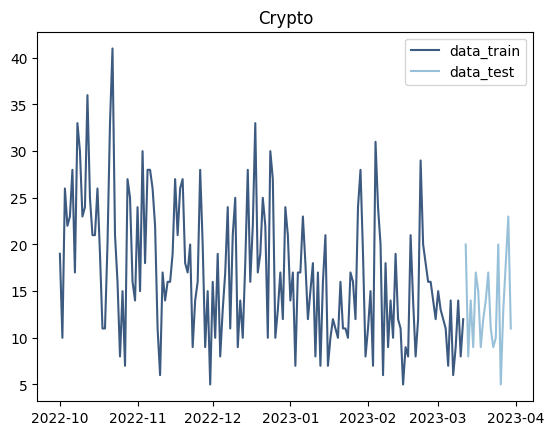

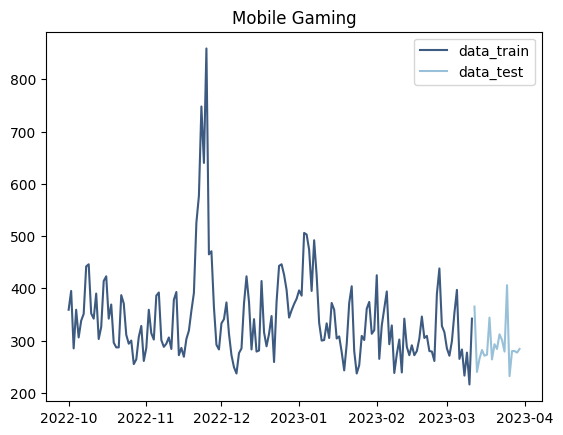

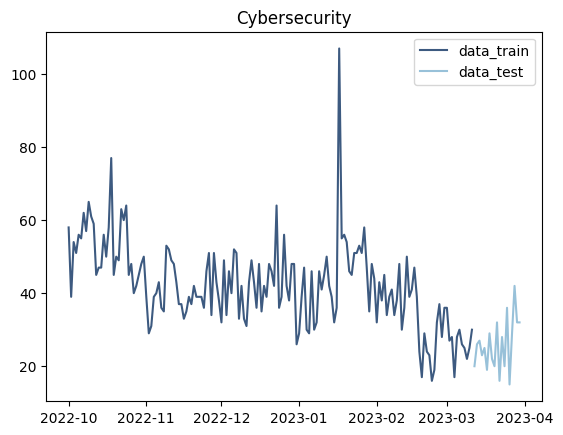

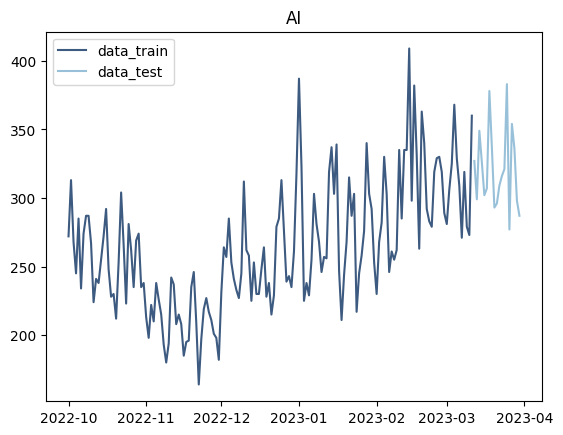

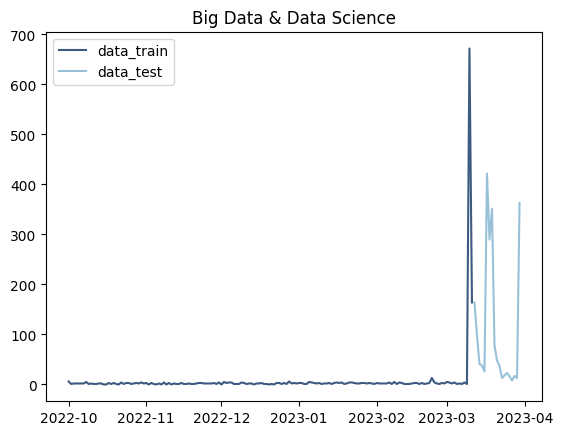

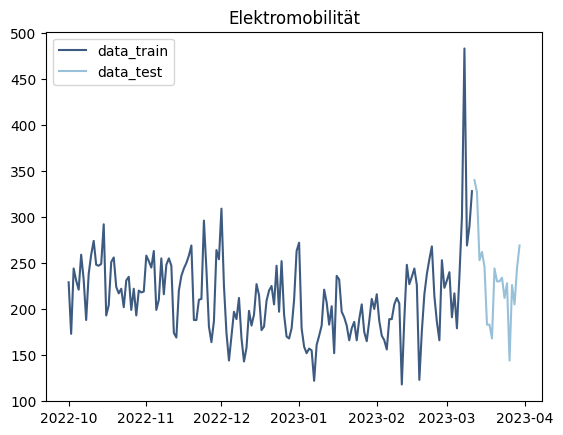

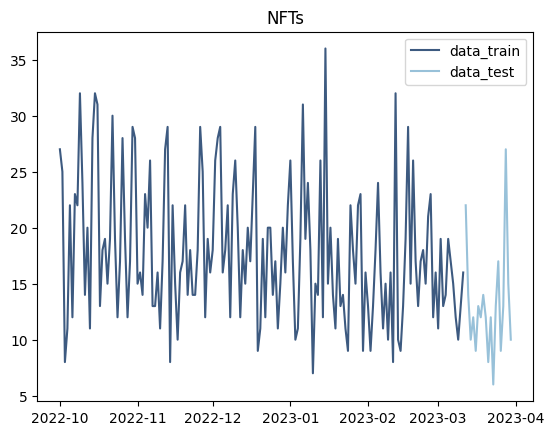

In [35]:
import matplotlib.pyplot as plt

for xgb_model in xgb_models:
    plt.plot(xgb_model.data_train, label='data_train', color='#3d5a80')
    plt.plot(xgb_model.data_test, label='data_test', color='#98c1d9')
    plt.legend()
    plt.title(xgb_model.label)
    plt.show()
    print('\n\n')

### Feature Engineering

Identifizieren Sie relevante Features und extrahieren Sie diese aus den vorhandenen Daten. Dies kann das Hinzufügen von Lag-Features, Aggregatfunktionen (z. B. Durchschnitt, Summe) über bestimmte Zeiträume oder das Hinzufügen von Zeitindikatoren (z. B. Monat, Tag der Woche) umfassen.

In [36]:
def create_features(data:pd.DataFrame):
    # zeitbasierten Features
    data['day'] = data.index.day
    data['week'] = data.index.isocalendar().week.astype(int)
    data['month'] = data.index.month
    data['weekday'] = data.index.weekday
    return data

for xgb_model in xgb_models:
    xgb_model.data_train_features = create_features(xgb_model.data_train.copy())
    xgb_model.data_test_features = create_features(xgb_model.data_test.copy())

### Modeling

In [37]:
import xgboost as xgb

FEATURES = ['day', 'week', 'month', 'weekday']
TARGET = 'count'

for xgb_model in xgb_models:
    # Trainingsdaten & Testdaten
    X_train = xgb_model.data_train_features[FEATURES]
    y_train = xgb_model.data_train_features[TARGET]
    X_test = xgb_model.data_test_features[FEATURES]
    y_test = xgb_model.data_test_features[TARGET]
    
    # Modell erstellen und trainieren
    reg = xgb.XGBRegressor(n_estimators=1000)
    reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=False)
    xgb_model.model = reg
    
    # Vorhersagen für Trainingsdaten
    xgb_model.data_test_features_predictions = xgb_model.data_test_features.assign(predictions=reg.predict(X_test))

### Evaluation

Kombiniere visuelle Auswertung mit statistischen Kennzahlen

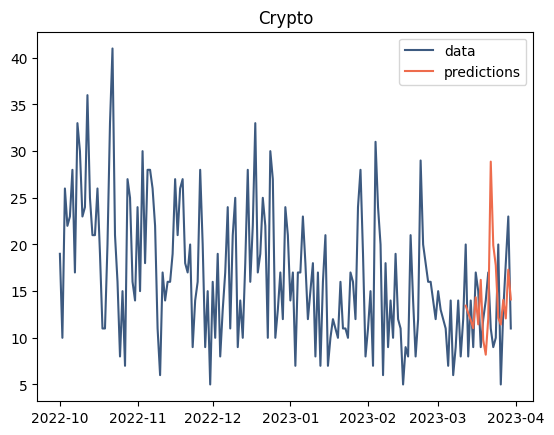

Average value of the dependent variable (AVG): 13.4211
MAE: 5.702931353920384
MAPE: 0.5053877665853576
RMSE: 6.836145853033707





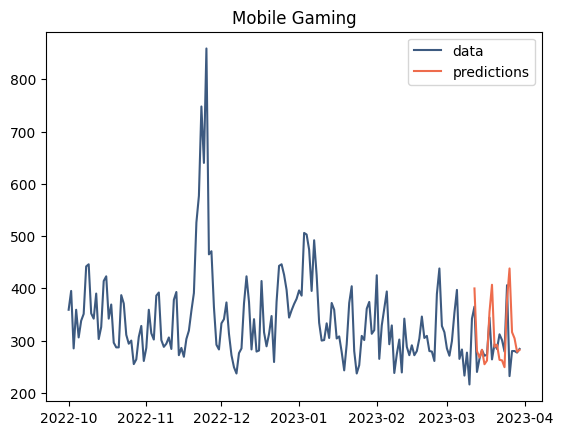

Average value of the dependent variable (AVG): 291.1579
MAE: 36.141855340254935
MAPE: 0.13517197999409247
RMSE: 62.27694474382751





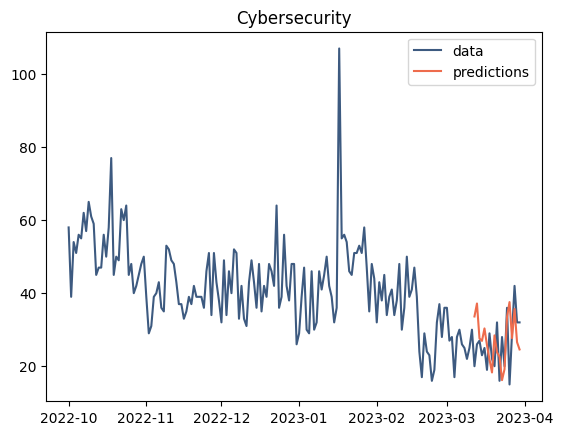

Average value of the dependent variable (AVG): 25.9474
MAE: 7.036190334119294
MAPE: 0.3164911019155406
RMSE: 8.670930598059192





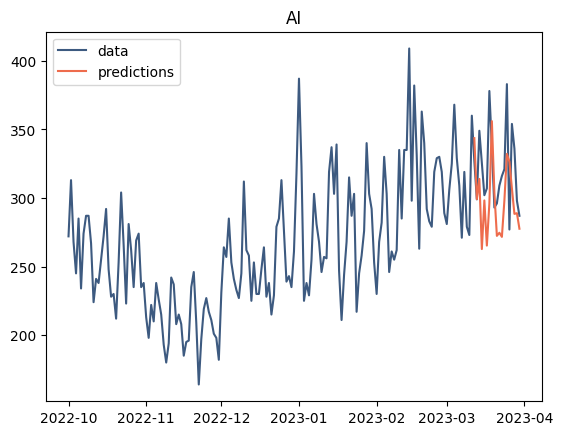

Average value of the dependent variable (AVG): 320.7895
MAE: 32.16636256167763
MAPE: 0.09771157693726543
RMSE: 38.65363803814071





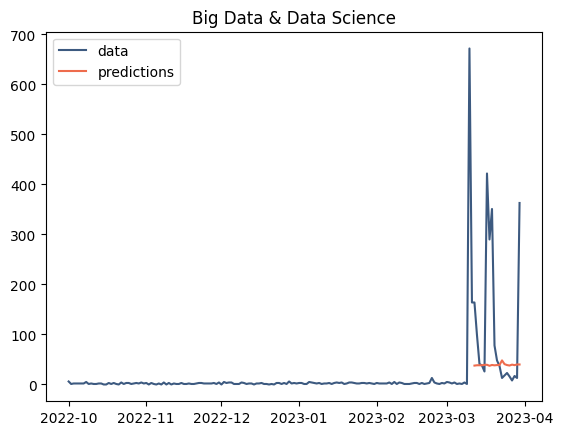

Average value of the dependent variable (AVG): 108.6842
MAE: 89.48197053608142
MAPE: 1.0322344554859602
RMSE: 151.83675935309506





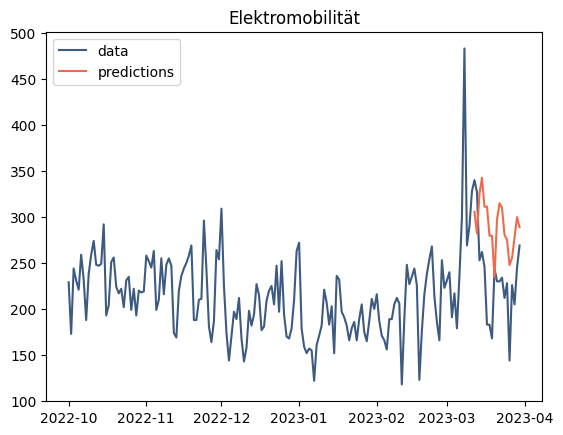

Average value of the dependent variable (AVG): 233.1053
MAE: 66.71044921875
MAPE: 0.31826403061631564
RMSE: 73.3532279194158





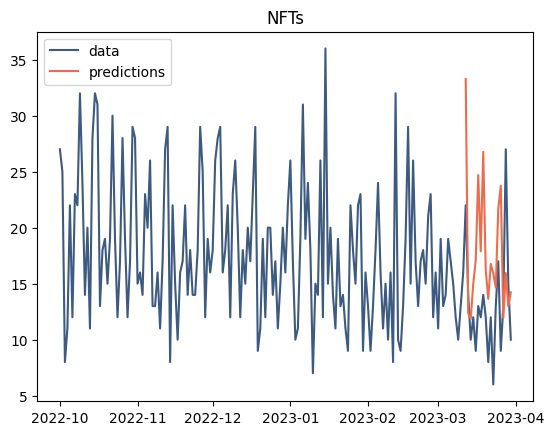

Average value of the dependent variable (AVG): 13.0526
MAE: 6.322563723513954
MAPE: 0.5503137949937423
RMSE: 7.6083082098838375





In [39]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
import pandas as pd

for xgb_model in xgb_models:
    _ = pd.concat([xgb_model.data_train_features, xgb_model.data_test_features_predictions])
    _.drop(FEATURES, axis=1, inplace=True)
    plt.plot(_['count'], label='data', color='#3d5a80')
    plt.plot(_['predictions'], label='predictions', color='#ee6c4d')
    plt.legend()
    plt.title(xgb_model.label)
    plt.show()
    
    avg = xgb_model.data_test_features[TARGET].mean()
    mae = mean_absolute_error(xgb_model.data_test_features[TARGET], xgb_model.data_test_features_predictions['predictions'])
    mape = mean_absolute_percentage_error(xgb_model.data_test_features[TARGET], xgb_model.data_test_features_predictions['predictions'])
    rmse = mean_squared_error(xgb_model.data_test_features[TARGET], xgb_model.data_test_features_predictions['predictions'], squared=False)
    
    print(f'Average value of the dependent variable (AVG): {round(avg, 4)}')
    print(f'MAE: {mae}')
    print(f'MAPE: {mape}')
    print(f'RMSE: {rmse}')
    
    print('\n\n')

---